# k-Nearest Neighbours

k-Nearest Neighbours (kNN) is a simple yet powerful classification algorithm. It relies upon a majority vote of the k-number of nearest neighbours of a data point to classify said data point.

kNN is a supervised non-parametric machine learning algorithm typically (though not exclusively) used for classification. kNN uses instance-based learning (i.e., lazy learning) requiring no training data for model creation.

This Notebook will showcase an application of the kNN algorithm using a dataset for predicting the success of bank telemarketing. It will first showcase kNN by building the algorithm by hand and applying it to a simple 2-dimensional problem, before further illustrating the usefulness of kNN using pre-created packages within a larger n-dimensional space. Afterwards, it will also apply kNN to a prediction problem using regression to show how it can be useful outside of classification.

Dataset citation:
*[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, In press,* 
*http://dx.doi.org/10.1016/j.dss.2014.03.001*

  *Available at: [pdf] http://dx.doi.org/10.1016/j.dss.2014.03.001*
                *[bib] http://www3.dsi.uminho.pt/pcortez/bib/2014-dss.txt*

*NOTE: This Notebook is NOT a recreation of the analysis run by Moro et al. (2014). It simply uses the same dataset.*

## Table of contents <a name="TOC"></a>
1. [Data cleaning](#cleaning)
    1. [Data overview](#data_overview)
    2. [Data cleaning](#data_cleaning)
2. [Exploratory data analysis](#descriptives)
    1. [Categorical variables](#cat_vars)
    2. [Settling a curiosity](#curious1)
    3. [Continuous variables](#con_vars)
        1. [Time-based variables](#con_vars_time_based)
        2. [Settling another curiosity](#curious2)
        3. [Client-based variables](#con_vars_client_based)
        4. [Correlations](#descriptives_correlations)
3. [Building kNN](#building)
    1. [Prerequisite choices](#building_choices)
        1. [Distance](#building_distance)
        2. [Procedure](#building_procedure)
        3. [*k* neighbours to use](#building_k_neighbours)
        4. [Performance](#building_performance)
        5. [Variables](#building_vars)
    2. [Algorithm creation](#building_algorithm)
4. [kNN using packages](#packages)
5. [kNN for regression](#regression)

### Import libraries

In [251]:
import numpy as np
import pandas as pd
import seaborn as sns
# %load_ext cudf.pandas # pandas on GPU (Note: only works for Nvidia GPUs)
import matplotlib.pyplot as plt

### Import data

In [38]:
data = pd.read_csv("bank-additional-full.csv", delimiter=";")

## Data cleaning <a name="cleaning"></a>
[Table of contents](#TOC)

### Data overview <a name="data_overview"> </a>

In [39]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


The dataset is too large to easily get an impression viewing just the head. It's fruitful to dive in a little deeper.

In [40]:
data.shape

(41188, 21)

The dataset contains 41,188 instances (observations) and 21 attributes (variables).

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

The dataset contains the following variables (*descriptions from data documentation*):

1. **age** (numeric)
2. **job** : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
3. **marital** : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
4. **education** (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
5. **default**: has credit in default? (categorical: "no","yes","unknown")
6. **housing**: has housing loan? (categorical: "no","yes","unknown")
7. **loan**: has personal loan? (categorical: "no","yes","unknown")
8. **contact**: contact communication type (categorical: "cellular","telephone") 
9. **month**: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
10. **day_of_week**: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
11. **duration**: last contact duration, in seconds (numeric). *Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*
12. **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. **previous**: number of contacts performed before this campaign and for this client (numeric)
15. **poutcome**: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
16. **emp.var.rate**: employment variation rate - quarterly indicator (numeric)
17. **cons.price.idx**: consumer price index - monthly indicator (numeric)     
18. **cons.conf.idx**: consumer confidence index - monthly indicator (numeric)     
19. **euribor3m**: euribor 3 month rate - daily indicator (numeric)
20. **nr.employed**: number of employees - quarterly indicator (numeric)
21. **y** - has the client subscribed a term deposit? (binary: "yes","no") *The outcome variable of this dataset*

### Data cleaning <a name="data_cleaning"></a>
[Table of contents](#TOC)

As mentioned in the data documentation the "duration" variable should only be used for benchmark purposes, and not for making any predictions. Benchmarking is not of interest here, so the variable can be dropped.

In [42]:
data.drop(columns=['duration'], inplace=True)

Some of the categorical variables seem to have missing values coded as "unknown" (namely: *job*, *marital status*, *education level*, *credit in default*, *housing loan*, and *personal loan*). Whereas the reasons for the missing values are valid, they are currently coded as class labels. To see whether this is likely to introduce bias into the models let's investigate their pervasiveness.

In [43]:
unknown_lst = ['job', 'marital', 'education', 'default', 'housing', 'loan'] # list of variables containing the 'unknown' class
for variable in unknown_lst:
    counts = data[variable].value_counts(dropna=False) # counts of each value option - including NAs as their own category
    print(f'Variable: {variable} || "unknown" count: {counts["unknown"]} || "unknown" percentage: {round(counts["unknown"]/len(data[variable])*100, 2)}%') # print relevant numbers for the "unknown" category

Variable: job || "unknown" count: 330 || "unknown" percentage: 0.8%
Variable: marital || "unknown" count: 80 || "unknown" percentage: 0.19%
Variable: education || "unknown" count: 1731 || "unknown" percentage: 4.2%
Variable: default || "unknown" count: 8597 || "unknown" percentage: 20.87%
Variable: housing || "unknown" count: 990 || "unknown" percentage: 2.4%
Variable: loan || "unknown" count: 990 || "unknown" percentage: 2.4%


5 out of the 6 potentially problematic variables have very low occurences of missing values, and do not warrant any immediate action. Only the 'default' variable seems to have a high enough occurence to lead to potentially significant bias in the models. Let's investigate this variable further.

In [44]:
data['default'].value_counts(dropna=False)

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

Upon further investigation of the 'default' variable, it can be seen that the 'yes' category only occurs 3 times (0.007%). Given that this variable is otherwise a binary variable (ignoring the missing value category), there does not seem to be any useful information contained within it, and it will therefore be dropped.

In [45]:
data.drop(columns=['default'], inplace=True)

For the remaining 5 categorical variables which seemed to not present any issues at first, let's double-check to make sure the "unknown" class is not a dominant class (among the most frequent classes).

In [46]:
unknown_lst.remove('default') # remove 'default' from the previously used list
for variable in unknown_lst:
    counts = data[variable].value_counts(dropna=False) # counts of each value option - including NAs as their own category
    print(f'Variable: {variable} || "unknown" frequency rank: {counts.index.get_loc("unknown") + 1}/{len(counts)}') # print out the frequency rank of the "unknown" category

Variable: job || "unknown" frequency rank: 12/12
Variable: marital || "unknown" frequency rank: 4/4
Variable: education || "unknown" frequency rank: 7/8
Variable: housing || "unknown" frequency rank: 3/3
Variable: loan || "unknown" frequency rank: 3/3


For 4 out of these 5 variables the "unknown" class is the least frequent of the classes. This combined with the low pervasiveness found before gives no cause for concern. Only the 'education' variable has the "unknown" class as the penultimate class. Let's dive a little deeper into this variable.

In [47]:
data['education'].value_counts(dropna=False)

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

It can be seen that only the "illiterate" class is found less frequently than the "unknown" class in the 'education' variable. This class has an extremely low count of only "18" occurences. Overall, there does not seem to be large enough concerns regarding this variable to take any actions.

Moving on from the categorical variables to the continuous ones, the next variable that could cause problems is the 'pdays' variable. This variable contains the number of days that have passed since the client was last contacted from a previous campaign. This is a numeric variable which includes '999' as the indicator that a client was not previously contacted. This can cause problems for the models where this value could be interpreted as a valid value. Before deciding how to proceed let's first see how pervasive the '999' value is within the variable.

In [48]:
print(data['pdays'].value_counts(dropna=False))
print(f'"999" percentage: {round(data["pdays"].value_counts(dropna=False)[999]/len(data["pdays"])*100, 2)}%')

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: pdays, dtype: int64
"999" percentage: 96.32%


The "999" value within the 'pdays' variable is by far the most dominant one (96.32%). This could constitute a problem for the models if left unchanged.

Unlike the 'default' variable from before the remaining information (the other 3.68%) within the 'pdays' variable seems to still contain useful information. For this reason dropping the variable altogether would be unwise. Since the "999" value has a distinct meaning, and is not actually a missing value imputation here is also not applicable. Additionally, "0" is also a valid value (and is actually found 15 times within the data), and is therefore also not an option for replacement. 

The highest value besides the "999" that is found within the data is "27", which is linearly far removed from the "999". Luckily the kNN algorithm does not impose a linear structure to the data (unlike for example linear regression), so this might not constitute a problem. kNN is only concerned with distance to other data points. Given the far distance (on this dimension) of the "999" value and the rest of the values it does already hold a distinct spot within the dimensional space - i.e., it will never be the nearest neighbour (on this dimension) to any of the other (non "999") values. This suggests that it might be possible to leave the "999" unchanged for the 'pdays' variable.

One final option is to replace the "999" value with a non-value value - e.g., Null, None, or NA. Python has distinct qualities for handling these values, though it is unclear exactly how this will impact the kNN algorithm. This is something to experiment with in the [kNN using packages](#packages) section.

For now, the variable will be left unchanged.

A final check to make is to see if there any additional missing values in the dataset (that have not been explicitly handled already)

In [49]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

There are no exlicitly missing values in the data.

## Exploratory data analysis <a name="descriptives"></a>
[Table of contents](#TOC)

### Categorical variables <a name="cat_vars"></a>
For the categorical variables it's a good idea to look at the frequency distributions to see if there are any peculiarities.

In [50]:
for variable in data.columns:
    if data[variable].dtype == "O": # "O" -> object - the pandas class for categorical variables
        print(data[variable].value_counts())

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
yes        21576
no         18622
unknown      990
Name: housing, dtype: int64
no         33950
yes         6248
unknown      990
Name: loan, dtype: int64
cellular     26144
telephone    15044
Name: contact, dtype: int64
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546


The categorical data seems to present a fairly balanced sample on most variables:

-  **job**: The most frequent job is administrative work, and the least frequent job is student (ignoring the missing value class as discussed above). All other jobs seem to be decently represented.
-  **marital**: Most clients are married. About half that number is single, and about half that number is divorced or widowed.
-  **education**: Most clients have a university degree, but all other levels of education are also decently represented. Only 'illiterate' is barely represented. The data is from Portugal, which has a low illiteracy rate (3.2% - according to the *World Data Atlas* (2021)).
-  **housing**: More people have a housing loan or mortgage (52.47%) than don't (45.28%).
-  **loan**: Most people do not have a personal loan (82.56%). Only a small portion has a personal loan (15.19%).
-  **contact**: More people have been contacted by cellular phone (63.58%), than by landline telephone (36.58%).
-  **month**: Most people were last contacted during the end-of-spring & beginning-of-summer period (May, June, July & August). Some of the other months (e.g., December) have very few last contacts. The documentation specifies that the campaign started in May 2008, and ended in November 2010. This could explain some of the monthly differences, as fewer Decembers occurred than Mays, for example. However, even accounting for the difference in occurences, it seems like there are periodic differences in last contacts. Additionally, the months January and February never occur in the data. The documentation of the data does list both of these months as possible options for this variable, leaving it unclear as to why they are absent.
-  **day_of_week**: The split of last contacts during the week is fairly uniformly distributed. No contacts were made on the weekend.
-  **poutcome**: Most clients were not involved in a previous marketing campaign, making the most common outcome of that campaign 'nonexistent'. Among the clients that were part of  a previous campaign there is a roughly 3:1 split in favour of 'failure' within this dataset. Unfortunately we do not know whether clients were sampled proportionally from the 'success' and 'failure' populations of previous campaigns, otherwise an effectiveness comparison of those campaigns and the current campaign could have been made.
-  **y**: 4640 (11.28%) of clients signed up for a term deposit product at the end of this campaign. 36,548 (88.88%) did not sign up for a term deposit product at the end of the campaign.

#### <span style="color:blue">Settling a curiosity</span><a name="curious1"></a>
[Table of contents](#TOC)

Though it is not relevant for the further analysis I would still like to have a further look at the 'month' variable. I am curious to see if the success rate of the campaign shows any patterns or trends throughout the campaign period.

This is simply a curiosity of mine which I would like to settle :)

In order to investigate this, I must first split the data according to the months within the period. Unfortunately, the dataset does not include a date-type variable, so I will have to infer this myself. Luckily, the data is provided chronologically which will make this process a bit easier.

Since datapoints are only added once a yes/no (the 'y' variable) decision has been made, there is no quarantee that each day of the campaign period is included in the data. This means that inferring a precise date from the provided information will not be possible. The best I can do is try to link each month with the year in which it most likely occurred.

To do this, I will take a change in the 'month' value to mean that the next month has occurred and use this logic to infer which year should be associated with this month. Technically, this procedure runs the risk of erring if a full 12 month period were to have occurred in which no new datapoints were added. In this case I would miss the change from one year to the next. However, chances of this having happened are rather low, so I will take the risk here.

In [87]:
month_year = [] # list that will contain the new month-year variable
last_month = "feb" # the previous month - technically february at the start of the campaign
current_year = 2008 # the current year - 2008 at the start of the campaign
month_rank = {  "mar": 3,
                "apr": 4,
                "may": 5,
                "jun": 6,
                "jul": 7,
                "aug": 8,
                "sep": 9,
                "oct": 10,
                "nov": 11,
                "dec": 12} # dictionary containing the rank of the months - necessary for inferring a year change

for month in data['month']:
    if month != last_month:
        if last_month != "feb": # ignore the initial change from (non-existent) February, 2008 to March, 2008
                if month_rank[last_month] > month_rank[month]: # if the previous month occurred later in the year than the current month, assume a year has passed
                    current_year += 1
        last_month = month
    month_year.append(month + ", " + str(current_year))

data['month_year'] = month_year # add the new list to the dataframe as a new column called 'month_year'
print(f'The included month-year data:\n {data["month_year"].unique()}')

The included month-year data:
 ['may, 2008' 'jun, 2008' 'jul, 2008' 'aug, 2008' 'oct, 2008' 'nov, 2008'
 'dec, 2008' 'mar, 2009' 'apr, 2009' 'may, 2009' 'jun, 2009' 'jul, 2009'
 'aug, 2009' 'sep, 2009' 'oct, 2009' 'nov, 2009' 'dec, 2009' 'mar, 2010'
 'apr, 2010' 'may, 2010' 'jun, 2010' 'jul, 2010' 'aug, 2010' 'sep, 2010'
 'oct, 2010' 'nov, 2010']


It seems that the only month completely absent from the data (besides every January and February) is September, 2008.

Seeing the data like this makes me wonder whether the success rate of the campaign shows any patterns beyond the simple occurrences that were found above. Let's look into this next. Plotting the data along with generating the success rates for each month-year seems like a good place to start. Additionally, the number of last contacts made each month could also show something interesting. The descriptive statistics above showed great variation in this among the different months.

Month: may, 2008 || successes: 240 || total: 7763 || success rate: 3.09%
Month: jun, 2008 || successes: 188 || total: 4374 || success rate: 4.3%
Month: jul, 2008 || successes: 407 || total: 6685 || success rate: 6.09%
Month: aug, 2008 || successes: 271 || total: 5175 || success rate: 5.24%
Month: oct, 2008 || successes: 42 || total: 67 || success rate: 62.69%
Month: nov, 2008 || successes: 190 || total: 3616 || success rate: 5.25%
Month: dec, 2008 || successes: 1 || total: 10 || success rate: 10.0%
Month: mar, 2009 || successes: 126 || total: 282 || success rate: 44.68%
Month: apr, 2009 || successes: 442 || total: 2458 || success rate: 17.98%
Month: may, 2009 || successes: 524 || total: 5794 || success rate: 9.04%
Month: jun, 2009 || successes: 264 || total: 715 || success rate: 36.92%
Month: jul, 2009 || successes: 66 || total: 178 || success rate: 37.08%
Month: aug, 2009 || successes: 264 || total: 770 || success rate: 34.29%
Month: sep, 2009 || successes: 106 || total: 267 || succes

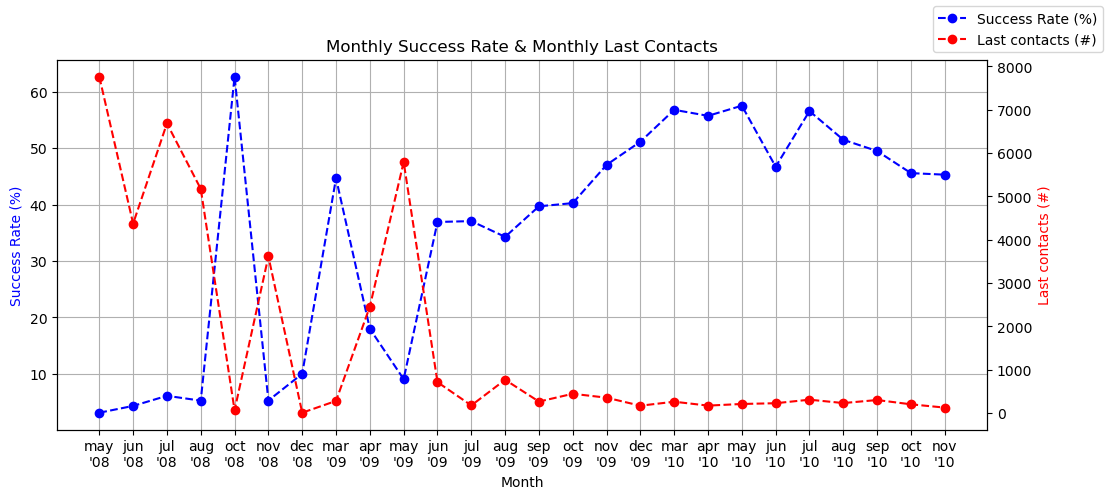

In [140]:
monthly_success = [] # list to store the monthly success rates in
monthly_total = [] # list to store the monthly number of last contacts in
for month in data["month_year"].unique():
    success = len(data.loc[(data['month_year'] == month) & (data['y'] == 'yes')]) # count of how many people signed up for a product within a given month
    total = len(data.loc[data['month_year'] == month]) # count of how many people had their last contact in a given month
    success_rate = success/total*100
    monthly_success.append(success_rate)
    monthly_total.append(total)
    print(f'Month: {month} || successes: {success} || total: {total} || success rate: {round(success_rate, 2)}%')

### Plotting the success rates and number of last contacts for each month ###

# Changing the month_year data for easier plotting
month_year_num = []
for month in data["month_year"].unique():
    month_num = month[:3]
    year_num = month[-2:]
    month_year_num.append(str(month_num) + "\n'" + str(year_num)) # the abbreviated month, with the final two digits of the year underneath

# Plotting the data
fig, ax1 = plt.subplots()
fig.set_figwidth(12)
ax2 = ax1.twinx() # duplicate for a second y-axis
ax1.plot(month_year_num, monthly_success, '--bo')
ax2.plot(month_year_num, monthly_total, '--ro')
# Adding aesthetic elements
plt.title("Monthly Success Rate & Monthly Last Contacts")
ax1.grid(True)
plt.tick_params(axis='x', labelsize=8)
ax1.set_xlabel("Month")
ax1.set_ylabel("Success Rate (%)", color='b')
ax2.set_ylabel("Last contacts (#)", color='r')
fig.legend(["Success Rate (%)", "Last contacts (#)"])
plt.show()

Looking at the output a few things stand out:
-  In roughly the first half of the campaign the number of last contacts per month peaked well into the thousands, whereas in the second half of the campaign the monthly last contacts are quite stable below 500.
-  The success rate shows an opposite trend, with the initial half of the campaign have a success rate below 10%, save for a few very high outliers during months with a very low number of last contacts. During the second half of the campaign the success rate is steadily above 30-40%.

Based on these numbers I posit that during the start of the campaign a large number of clients quickly decided that they were not interested in the product offering, and stepped out of the campaign. This created a subset during the second half of the campaign of fewer, but more interested clients. The success rate on this smaller group of clients was then much higher.

I would like to investigate this theory further, and see if any evidence for it can be found. To this end I will have a look at the 'campaign' variable, which contains the number of times a clients was contacted during this campaign before making their final decision. If my theory holds, then we should see a relatively low number of campaign contacts in the beginning of the campaign period, which then increases as the campaign carries on before peaking at the end.

To investigate this, let's have a look at the average of the number of contacts each client received up until their final month, for each of the months.

Month: may, 2008 || average # contacts: 2.51 || max # contacts: 56 || stdev contacts: 2.65
Month: jun, 2008 || average # contacts: 3.36 || max # contacts: 41 || stdev contacts: 4.04
Month: jul, 2008 || average # contacts: 3.24 || max # contacts: 43 || stdev contacts: 3.84
Month: aug, 2008 || average # contacts: 2.84 || max # contacts: 27 || stdev contacts: 2.7
Month: oct, 2008 || average # contacts: 1.0 || max # contacts: 1 || stdev contacts: 0.0
Month: nov, 2008 || average # contacts: 1.91 || max # contacts: 11 || stdev contacts: 1.38
Month: dec, 2008 || average # contacts: 1.0 || max # contacts: 1 || stdev contacts: 0.0
Month: mar, 2009 || average # contacts: 2.51 || max # contacts: 22 || stdev contacts: 2.61
Month: apr, 2009 || average # contacts: 1.94 || max # contacts: 23 || stdev contacts: 1.47
Month: may, 2009 || average # contacts: 2.36 || max # contacts: 15 || stdev contacts: 1.86
Month: jun, 2009 || average # contacts: 1.75 || max # contacts: 15 || stdev contacts: 1.22
Month:

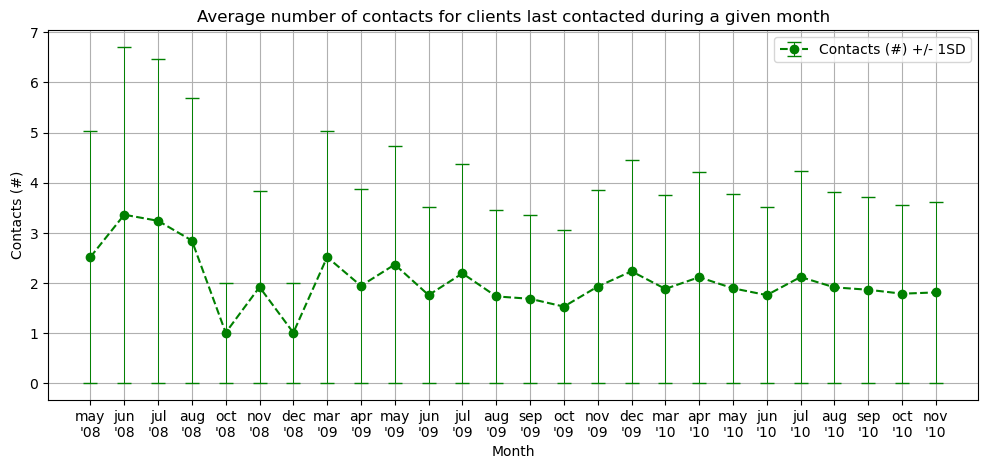

In [153]:
call_lst = [] # list to store the number of contacts in
std_call_lst = [] # to store the stdevs of the number of contacts in - for error bar plotting purposes
call_max_lst = [] # list to store the max number of contacts in
for month in data['month_year'].unique():
    calls = np.mean(data.loc[data['month_year'] == month]['campaign']) # average number of contacts for clients last contacted during a specific month
    std_calls = np.std(data.loc[data['month_year'] == month]['campaign']) # the stdev of the above mean
    max_calls = np.max(data.loc[data['month_year'] == month]['campaign']) # maximum number of contacts for clients last contacted during a specific month
    call_lst.append(calls)
    std_call_lst.append(calls)
    call_max_lst.append(max_calls)
    print(f'Month: {month} || average # contacts: {round(calls, 2)} || max # contacts: {max_calls} || stdev contacts: {round(std_calls, 2)}')

### Plotting the number of contacts for each month ###
# Plotting the data
plt.figure().set_figwidth(12)
plt.errorbar(month_year_num, call_lst, yerr=std_call_lst, fmt='--go', ecolor='g', capsize=5, elinewidth=0.7) # including error bars into the plot
# Adding aesthetic elements
plt.title("Average number of contacts for clients last contacted during a given month")
plt.xlabel("Month")
plt.ylabel("Contacts (#)")
plt.grid(True)
plt.legend(['Contacts (#) +/- 1SD'])
plt.show()

Looking at the output, my theory is not supported. Interestingly, the average number of contacts actually peaks in the beginning, before levelling out towards the end of the campaign. Differences are rather small though. It seems that most people were contacted around 2 times for the majority of the months.

The maximum contacts per month show something interesting. During the first 3 months the highest number of contacts a single client received were above 40! May, 2008 even saw a maximum of 56 times. That's approaching twice a day for the entire month. I have no theories or explanations for this.

Returning to the theory mentioned above, it does not seem like clients were contacted more frequently towards the end of the campaign compared to the beginning. This suggests that the population of clients were not all contacted immediately upon starting the campaign. Instead, some clients seem to have been contacted for the first time only towards the end of the campaign. My earlier theory assumed otherwise, and is therefore not supported.

Unfortunately, there's no completely satisfying ending to this curiosity detour. To prevent falling deeper into this rabbit hole and getting even more off-track, I will consider this curiosity unsettled yet properly explored :)

### Continuous variables <a name="con_vars"></a>
[Table of contents](#TOC)

For the continuous variables in the dataset it is a good idea to get some sense of their distributions. For this let's look at their *central tendency* and *variability*, and potential *outliers*. 

#### Time-based variables <a name="con_vars_time_based"></a>
Some of the variables are measured on a daily, monthly or quarterly basis. As seen above in the [*Descriptive Statistics* section on categorical variables](#descriptives) the months (captured by the newly made 'month_year' variable) are not uniformly represented - e.g., May, 2008 has 7763 observations, whereas December, 2008 only has 10. This problem naturally exists for the days within each month as well (though we do not have this data directly). 

For the quarters an additional problem exists: each year misses the months January and February, which creates 1 quarter per (full) year that is only represented by a single month. Additionally, the quarters included in the data start counting in March rather than January. This leads to Q1 consisting of March, April & May. Q2 consists of June, July & August. Q3 consists of September, October & November. Finally, Q4 consists of only December. The first year (2008) only starts in May, leaving both May and December of 2008 as the sole months comprising a quarter. On top of that, the month September is absent from that year, leaving the third quarter with only 2 months. The final year (2010) ends in November, leaving that year with only 3 quarters.*

This presents a problem for calculating the *central tendency* and *variability* of these variables, as they would be balanced on observations rather than occurrences. This would heavily skew these numbers towards the most often represented months and quarters.

To overcome this issue, only the unique values of each daily, monthly & quarterly variable will be used to calculate their *central tendency* and *variability*, and look at potential *outliers*.



**Finding all this out took a painstakingly long amount of time. I have no idea why the quarters were set up like this, nor what purpose this serves.*

In [187]:
# Getting descriptive statistics for all per-time variables
continuous_per_time_lst = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'] # list containing the variables which are measured on a per time (daily, monthly, or quarterly) basis, rather than a per client basis
for variable in continuous_per_time_lst:
    temp_data = data[variable].unique() # consider only the unique values for the upcoming calculations
    mean = np.mean(temp_data)
    median = np.median(temp_data)
    stdev = np.std(temp_data)
    mini = np.min(temp_data) # to look for outliers
    maxi = np.max(temp_data) # to look for outliers
    num = len(temp_data)
    print(f'Variable: {variable} || mean: {round(mean, 2)} || median: {round(median, 2)} || stdev: {round(stdev, 2)} || min: {round(mini, 2)} || max: {round(maxi, 2)} || n: {num}')

Variable: emp.var.rate || mean: -1.17 || median: -1.4 || stdev: 1.61 || min: -3.4 || max: 1.4 || n: 10
Variable: cons.price.idx || mean: 93.42 || median: 93.41 || stdev: 0.74 || min: 92.2 || max: 94.77 || n: 26
Variable: cons.conf.idx || mean: -39.22 || median: -39.9 || stdev: 6.39 || min: -50.8 || max: -26.9 || n: 26
Variable: euribor3m || mean: 1.66 || median: 0.97 || stdev: 1.44 || min: 0.63 || max: 5.04 || n: 316
Variable: nr.employed || mean: 5088.31 || median: 5076.2 || stdev: 90.51 || min: 4963.6 || max: 5228.1 || n: 11


An immediate issue arises. The two quarterly variables ('emp.var.rate' & 'nr.employed') differ in their occurrences. Given that the campaign started in May, 2008 and ended in November, 2010 there should be a total of 11 quarters. The discreptancy in the 'emp.var.rate' variable might be caused by two quarters sharing the same value. The procedure of taking the unique values would miss this, and only count one of the two quarters.

A potential second problem also exists. The 'euribor3m' variable shows a total of 316 unique occurrences. Since there is no true date variable in the dataset, there is a chance that the same problem as with the quarters has occurred here as well.

The unique values procedure worked correctly for the two monthly variables as 26 unique values were found for all of the months included in the dataset (no Januarys & Februarys, and no September, 2008). For these variables we can say the following:
-  **cons.price.idx**: the average consumer price index in Portugal throughout the campaign period was around 93. The range was between 92.2 and 94.77. This is below 100, suggesting lower consumer prices than during the base year. The mean and median values are quite similar, suggesting a balanced CPI throughout the period.
-  **cons.conf.idx**: the average consumer confidence index value in Portugal throughout the campaing period was around -39. The range was fully negative. This suggests a negative outlook of consumers towards the economy. This could be explained by the 2008 financial crisis. The mean and median values are relatively close, suggesting a roughly balanced CCI throughout the campaign period.

For the quarterly and daily variables some issues must be solved before looking at their descriptive statistics. The problem with the quarterly variables is easier to solve, so that will be tackled first.

In order to overcome the problem above, specific months ('month_year') for each quarter will be used to extract the quarterly values.

In [192]:
quarter_months_dict = { "Q1, 2008": "may, 2008",
                        "Q2, 2008": "jun, 2008",
                        "Q3, 2008": "oct, 2008",
                        "Q4, 2008": "dec, 2008",
                        "Q1, 2009": "mar, 2009",
                        "Q2, 2009": "jun, 2009",
                        "Q3, 2009": "sep, 2009",
                        "Q4, 2009": "dec, 2009",
                        "Q1, 2010": "mar, 2010",
                        "Q2, 2010": "jun, 2010",
                        "Q3, 2010": "sep, 2010"} # dictionary containing a month_year for each quarter in the dataset - I would have liked to do this more neatly, but the strange set-up of the quarters makes that overly complicated
quarter_vars = ['emp.var.rate', 'nr.employed'] # list containing the variables measured on a quarterly basis
quarter_values_dict = {} # dict to hold the quarter values - to be used later
for variable in quarter_vars:
    quarter_values = []
    for month in quarter_months_dict.values():
        quarter_values.append(np.mean(data.loc[data['month_year'] == month][variable])) # take the mean of the quarterly variable for the month_year specified in the dictionary - since this value is constant throughout this month, taking the mean will result in the same value as taking a single instant
    mean = np.mean(quarter_values) 
    median = np.median(quarter_values)
    stdev = np.std(quarter_values)
    num = len(quarter_values)
    mini = np.min(quarter_values)
    maxi = np.max(quarter_values)
    quarter_values_dict[variable] = quarter_values
    print(f'Variable: {variable} || mean: {round(mean, 2)} || median: {round(median, 2)} || stdev: {round(stdev, 2)} || min: {round(mini, 2)} || max: {round(maxi, 2)} || n: {num}')

Variable: emp.var.rate || mean: -1.23 || median: -1.7 || stdev: 1.54 || min: -3.4 || max: 1.4 || n: 11
Variable: nr.employed || mean: 5088.31 || median: 5076.2 || stdev: 90.51 || min: 4963.6 || max: 5228.1 || n: 11


Now that both the quarterly variables have the correct months linked to each quarter, they also both correctly show 11 values. Now the descriptive statistics can be examined:
-  **emp.var.rate**: the employment variation rate is -1.23 on average, indicating that on average more people became jobless each quarter than became employed. The median is a bit lower than the mean, suggesting that more quarters with below average rates were seen than with above average rates. The range runs from -3.4 to 1.4, indicating that at least some quarters saw more people becoming employed than becoming jobless.
-  **nr.employed**: the average quarterly number of employees within the bank was 5088. The median number is very similar. Additionally, the standard deviation is quite low, suggesting a fairly stable workforce. This is further supported by the relatively tight range of 4963 to 5228. Interestingly, the variable takes on decimal values. This could signify employees working parttime, or starting / leaving during a quarter.

#### <span style="color:blue">Settling another curiosity</span><a name="curious2"></a>
[Table of contents](#TOC)

The two quarterly variables above could theoretically be related. On the one hand there is the macro-economic employment variability rate, and on the other hand there is the firm-level number of employees. I wonder if the macro-economic effect can be seen on the firm level. This is not particularly relevant for the remaining analysis, but I am curious about it. 

So, let's try and settle another curiosity :) 

To start let's have a look at the correlation between the two variables, to see if there is any evidence of co-movement. For this I will calculate the Pearson product-moment correlation coefficient (PCC).

In [197]:
print(np.corrcoef(quarter_values_dict['emp.var.rate'], quarter_values_dict['nr.employed'])[1, 0])

0.765416388437279


We find a PCC ($r$) of ~0.765. This suggests a decently strong positive correlation between the two variables. This provides initial support for the proposed relationship.

Let's visualize the two variables for an even clearer picture.

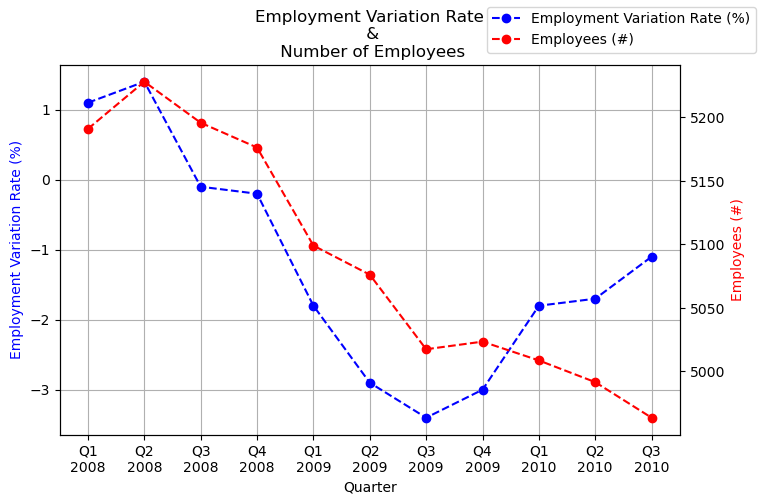

In [241]:
# Create a nice x-axis variable
quarters = [] # list to store the quarters in
year = 2007 # because 0 % n always equals 0...
quarter = 1
for i in range(len(quarter_values_dict['emp.var.rate'])):
    if i % 4 == 0:
        year += 1
        quarter = 1
    quarters.append("Q" + str(quarter) + "\n" + str(year))
    quarter += 1

# Plotting the data
fig, ax1 = plt.subplots()
fig.set_figwidth(8)
ax2 = ax1.twinx() # duplicate for a second y-axis
ax1.plot(quarters, quarter_values_dict['emp.var.rate'], '--bo')
ax2.plot(quarters, quarter_values_dict['nr.employed'], '--ro')
# Adding aesthetic elements
plt.title("Employment Variation Rate\n &\n Number of Employees")
ax1.grid(True)
plt.tick_params(axis='x', labelsize=8)
ax1.set_xlabel("Quarter")
ax1.set_ylabel("Employment Variation Rate (%)", color='b')
ax2.set_ylabel("Employees (#)", color='r')
fig.legend(["Employment Variation Rate (%)", "Employees (#)"])
plt.show()

The graph indeed shows high co-movement between the variables. Up until the fourth quarter of 2009 both variables seem to follow the same trend. However, afterwards the number of employees keeps falling, whereas the employment variation rate rises. A possible explanation of this could be a shrinkage of this particular bank following the 2008 financial crisis. Without knowing the exact bank that the data originated from though, this explanation cannot be verified. It could have just as easily been another firm decision unrelated to the financial crisis. Additionally, it could have not been led from the firm-side at all, but from the employee side as well. It's impossible to tell without more data.

Either way, this was an interesting detour! The macro-economic and firm-level variables measuring conceptually similar phenomenon, seem to move in similar ways.

I consider this curiosity satisfied :)

Moving on now to the variable measured on a daily basis ('euribor3m'). Earlier 316 unique values for this variable were found, suggesting 316 distinct days within the dataset. However, as with the quarterly variables, the unique values procedure does not guarantee to find all days. Days with duplicate values would only be counted as a single day. 

To get some more confidence that all distinct days were found a new procedure will be applied. For this procedure changes in other variables will be used to infer a day change, even when the 'euribor3m' variable does not change. For this procedure only variables which signify a change in day on their own can be used. Since most variables are measured on a per-client basis, rather than a per-time basis this excludes the majority of the variables already. 

The variables that remain are the monthly and quarterly variables, and the 'day_of_week' variable. The quarterly variables will add no information beyond that which is already included in the monthly variables, so those don't have to be considered separately. The reasoning here is that the only situation in which a quarterly variable changes while a monthly variable will not is if there is a full 1-year gap in the data, which has already been found to not be the case. A change in the 'day_of_week' variable obviously also signifies a change in day. Unfortunately, it is possible that the data contains a one-week gap (where a new datapoint is from a different day, but the 'day_of_week' variable has not changed, since both the new and the previous datapoint both occurred on a Monday, for example). Unfortunately, it is not possible to catch all of these instances with 100% accuracy - that information is simply absent from the dataset. However, we can catch some of these instances by also considering changes in the two monthly variables. *Note: this procedure is only possible because the data is in chronological order.*

The procedure will then look as follows: a change in either the 'euribor3m', 'day_of_week', 'cons.price.idx', or 'cons.conf.idx' variables will be taken to indicate a change of day.

In [243]:
euribor_daily_values = [] # list to store the daily euribor values in
last_euribor = "start" # last known value of the euribor (set to "start" for the start of the campaign)
last_day = "start" # previous day (set to "start" for the start of the campaign)
last_cons_price = "start" # last value of the consumer price index (set to "start" for the start of the campaign)
last_cons_conf = "start" # last value of the consumer confidence index (set to "start" for the start of the campaign)

# Filling the values list for the euribor3m
for i in range(len(data)):
    if (data['euribor3m'][i] != last_euribor) or (data['day_of_week'][i] != last_day) or (data['cons.price.idx'][i] != last_cons_price) or (data['cons.conf.idx'][i] != last_cons_conf): # a change in any of these variables signifies a change in day
        euribor_daily_values.append(data['euribor3m'][i]) # add the new daily euribor3m value to the list of values
        last_euribor = data['euribor3m'][i]
        last_day = data['day_of_week'][i]
        last_cons_price = data['cons.price.idx'][i]
        last_cons_conf = data['cons.conf.idx'][i]

# Print out the descriptive statistics
mean = np.mean(euribor_daily_values) 
median = np.median(euribor_daily_values)
stdev = np.std(euribor_daily_values)
num = len(euribor_daily_values)
mini = np.min(euribor_daily_values)
maxi = np.max(euribor_daily_values)
print(f'Variable: euribor3m || mean: {round(mean, 2)} || median: {round(median, 2)} || stdev: {round(stdev, 2)} || min: {round(mini, 2)} || max: {round(maxi, 2)} || n: {num}')

Variable: euribor3m || mean: 1.84 || median: 0.91 || stdev: 1.65 || min: 0.63 || max: 5.04 || n: 490


The number of distinct days in the dataset has gone up from 316 with the unique values method to 490 with the new method. 490 working days (weekends are not included in the data) are 98 weeks, or approximately 22.5 months (assuming 4.345 weeks per month). Given the absence of the shortest month (February) from the data, and the low number of observations for some of the months (e.g., only 10 for December, 2008) this seems reasonable. Now the discriptive statistics can be examined:
-  **euribor3m**: the Euribor 3-month rate was 1.84% on average throughout the campaign period. The median rate was much lower at 0.91%, suggesting a large inbalance between above and below average days, in favor of below average. The range of the 3-month rate is rather wide, with 0.63% on the low end and 5.04% on the high end.

The rate can be visualised graphically as well.

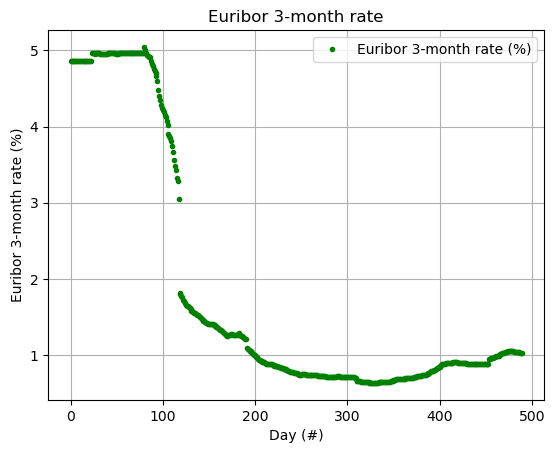

In [242]:
# Plotting the data
plt.plot(euribor_daily_values, '.g')
# Adding aesthetic elements
plt.title("Euribor 3-month rate")
plt.xlabel("Day (#)")
plt.ylabel("Euribor 3-month rate (%)")
plt.grid(True)
plt.legend(['Euribor 3-month rate (%)'])
plt.show()

The graph further supports the idea that the 3-month rate was below the average (1.84%) for the majority of the campaign period. The graph further shows that in the beginning of the campaign period the 3-month rate was significantly higher. Around the 100-day mark the rate plummeted from around 5% all the way down to below 2%. It leveled out towards the end of the campaign around 1%. The stark drop in the Euribor rate can be explained by the European response to the 2008 financial crisis.

It is possible that this drop can explain some of pattern of the success rates for the term deposit that were discovered before. This is speculatory at best however, as no details on the product offering are known. Additionally, it is unclear to what extent the Euribor would have translated to higher or lower interest rates for banking clients. Without additional information it is impossible to assess the relative attractiveness of the offer in relation to other offered deposit rates.

#### Client-based variables <a name="con_vars_client_based"></a>
[Table of contents](#TOC)

The remaining continuous variables are all measured on a per-client basis, rather than a per-time basis. Since the dataset is also on a per-client basis, no additional modifications to these variables have to be made. Their *central tendency* and *variability* can be directly assessed. The only exception to this is the 'pdays' variable which consists for a large part of the value '999' to denote that a client had not been contacted in previous campaigns. Leaving this variable unchanged would heavily skew the descriptives upwards, so the value '999' will be excluded here.

In [246]:
# Getting descriptive statistics for all per-client variables (except 'pdays')
for variable in data.columns:
    if (variable not in continuous_per_time_lst) and (variable != 'pdays') and ((data[variable].dtype == "int64") or (data[variable].dtype == "float64")): # exluding 'pdays'
        print(round(data[variable].describe(), 2)) # as these variables are unchanged the Pandas "describe()"-function can be used

# The special case of 'pdays'
temp_pdays = data['pdays'].drop(data[data['pdays'] == 999].index) # temporarily drop all rows that have "999" as the value for 'pdays'
mean = np.mean(temp_pdays)
median = np.median(temp_pdays)
stdev = np.std(temp_pdays)
mini = np.min(temp_pdays)
maxi = np.max(temp_pdays)
print(f'Variable: pdays || mean: {round(mean, 2)} || median: {round(median, 2)} || stdev: {round(stdev, 2)} || min: {round(mini, 2)} || max: {round(maxi, 2)}')

count    41188.00
mean        40.02
std         10.42
min         17.00
25%         32.00
50%         38.00
75%         47.00
max         98.00
Name: age, dtype: float64
count    41188.00
mean         2.57
std          2.77
min          1.00
25%          1.00
50%          2.00
75%          3.00
max         56.00
Name: campaign, dtype: float64
count    41188.00
mean         0.17
std          0.49
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          7.00
Name: previous, dtype: float64
Variable: pdays || mean: 6.01 || median: 6.0 || stdev: 3.82 || min: 0 || max: 27


The per-client continuous variables' descriptive statistics show the following:

-  **age**: the average age of the clients is around 40. This is unsurprising for a banking institution. The median is close at 38 (50%-mark). The youngest client is 17, whereas the oldest is 98.
-  **campaign**: the average number of times a client was contacted during this campaign is 2.57, with the most common number of contacts being 2. The minimum number of contacts is 1, which makes perfect sense. The maximum number of contacts is 56! This seems somewhat excessive... The 'campaign' variable was also assessed in the [settling a curiosity section](#curious1). A detailed breakdown of this variable per month can be found there.
-  **previous**: the majority of clients were not contacted before this campaign (median = 0.0). Though some were (mean != 0.0). The minimum was obviously 0, whereas the maximum was 7.
-  **pdays**: as shown before in the [data cleaning](#data_cleaning) section the vast majority of clients (96.32%) were not contacted in a previous campaign. For the remaining clients the average number of days that passed after the client was last contacted during a previous campaign is around 6 days. The median value is essentially the same. The minimum value is 0 (besides technically '999'). This suggests that some clients were contacted about a previous campaign on the same day as they were contacted about this campaign. The maximum value is 27.

#### Correlations <a name="descriptives_correlations"></a>
[Table of contents](#TOC)

After gaining some understanding of each continuous variable individually, the next step is to start learning something about their relationships. Since there are a managable number of continuous attributes (variables) within the dataset, pairwise Pearson product-moment correlation coefficients (PCCs) can be calculated. These are most easily visualized in a correlation heatmap.

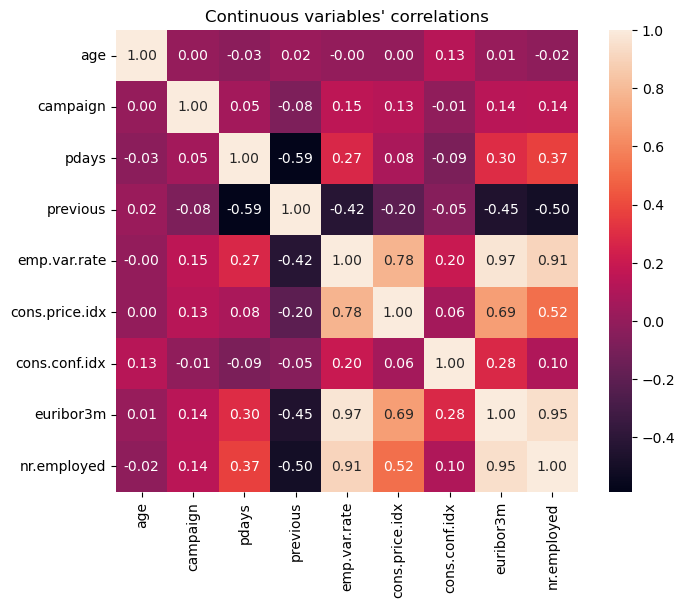

In [261]:
# Calculate the correlations
con_vars_correlations = data.corr(method="pearson", numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(8,6))
plt.title('Continuous variables\' correlations')
a = sns.heatmap(con_vars_correlations, square=True, annot=True, fmt='.2f', linecolor='white')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels())           
plt.show()

The heatmap shows low to moderate correlations for most variable pairs. Some stand out with higher correlations:
-  **Employment variation rate** ('emp.var.rate') & **consumer price index** ('cons.price.idx') have a correlation of 0.78, showing positive co-movement. This makes intuitive sense, as both variables pertain to the macro-economic state of Portugal. In additional to this logical argument, there is also a measurement argument, in that these are two variables which are both measured on a per-time basis (he employment variation rate is measured quarterly, while the consumer price index is measured monthly). This already sets it up in such a way that both variables occassionally change at the same time and for the same instances (clients).
-  **Euribor 3-month rate** ('euribor3m') & **employment variation rate** ('emp.var.rate') have a correlation of 0.97. This indicates almost perfect positive co-movement. The European response to the 2008 financial crisis might be able to explain part of this. As the stark decrease in the Euribor rate was a direct consequence of, among other things, the level of employment across Europe. On the measurement side, the correlation could be boosted by both variables being measured on a per-time basis, though they are not on the same time basis (Euribor is measured daily, whereas the employment variation rate is measured quarterly).
-  **Number of employees** ('nr.employees') & **employment variation rate** ('emp.var.rate') have a correlation of 0.91. This correlation has already been explored in the [settling another curiosity](#curious2) section. The correlation found here (0.91) is higher than the previously found correlation (0.76). This is because before the correlation was calculated with only the per-quarter values. Here, the correlation is calculated with the per-client values. Since most instances occurred in the earlier quarters the correlation calculation becomes biased towards that side of the data. During the earlier quarters the variables moved together more closely than during the later quarters, thereby inflating the correlation calculated here. This is precisely the reason for calculating the descriptive statistics of the per-time variables separately than those of the per-client variables. Since here all continuous variables are compared regardless of their measurement base, replicating the same procedure here is not possible.
-  **Euribor 3-month rate** ('euribor3m') & **consumer price index** ('cons.price.idx') have a correlation of 0.69. This makes sense as the CPI can be used as a proxy for inflation. Similarly, the Euribor rates can be used as a proxy for the European Central Bank (ECB) policy, part of which is trying to drive inflation. A positive correlation is not enough to proof a casual relationship here, but it is an indication.
-  **Euribor 3-month rate** ('euribor3m') & **number of employees** ('nr.employees') have a correlation of 0.95. This is near perfect positive co-movement. Some of this can be explained by both variables' relationship to the wider macro-economic environment. There is also the measurement driver already explained before. Finally, there is an argument to be made for a confounding variable sitting in between these two. In this case that would be the employment variation rate. Both the number of employees and the 3-month rate are highly correlated with the employment variation rate. Conceptually, the employment rate acts as a bridge from the ECB policy (as proxied by the Euribor rate) to the firm-level actions in terms of hiring and firing practices.

The highest negative correlations are only moderately strong:
-  **previous campaign contact** ('previous') & **days passed since last contact from a previous campaign** ('pdays') have a correlation of -0.59. This makes sense as the 'pdays' variable denotes clients who have not been contacted by '999'. Because of this, the more distant the last contact was the less likely the client was to have been contacted at all.
-  **previous campaign contact** ('previous') & **number of employees** ('nr.employees') have a correlation of -0.50. This correlation makes little sense logically. This may simply be a result of the distribution of clients throughout the quarters.
-  **previous campaign contact** ('previous') & **Euribor 3-month rate** ('euribor3m') have a correlation of -0.45. This makes no sense logically, as the previous contacts are determined independently from macro-economic activity, whereas the Euribor rate is actively being set throughout the campaign period. This correlation may also be driven by client distribution throughout the days.
-  **previous campaign contact** ('previous') & **employment variation rate** ('emp.var.rate') have a correlation of -0.42. Again, this makes little sense as the previous contacts are determined independently from any activity outside the firm. This correlation may also be driven by client distribution throughout the quarters.

Most of the correlations can be explained in a logical way, though some are puzzling. Particularly, the previous campaign contact ('previous') variable seems to be moderately (negatively) correlated with some of the per-time variables. There doesn't seem to be any logical reason behind this. A deeper analysis into these variables might be fruitful.

Beginning with the previous campaign contact ('previous') variable; a histogram of the distribution is a good starting point.

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64


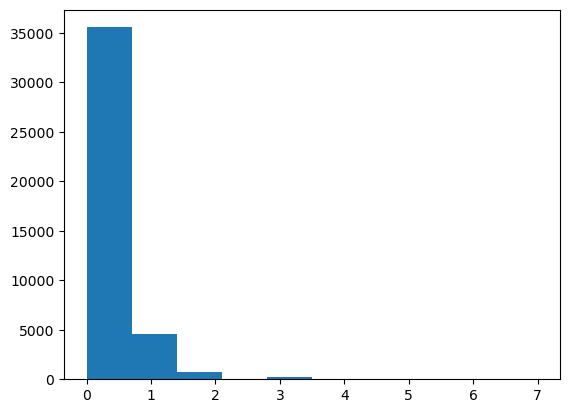

In [264]:
# The value counts of 'previous'
print(data['previous'].value_counts())

# Histogram of 'previous'
plt.hist(data['previous'])
plt.show()

Unsurprisingly, the vast majority (86.34%) of clients were not contacted for a previous campaign. Interestingly as that is, it does not give any explanation to the correlations with the time-based variables.

It is possible that some pattern exists within the per-time behavior of the 'previous' variable. To investigate this, both the average and the maximum value* of the 'previous' variable will be investigated.

**the maximum value is used as well, in case the mean value does not meaningfully change from 0.*

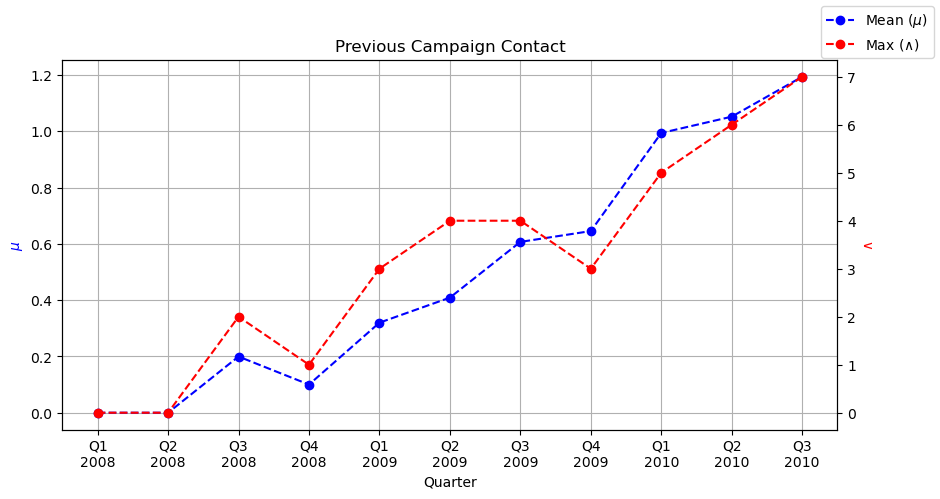

In [287]:
# 'previous' on a per-quarter basis
previous_mean_qrts_lst = [] # list to store the mean value per quarter in
previous_max_qrts_lst = [] # list to store the max value per quarter in

for val in quarter_values_dict['nr.employed']: # nr.employed should be used, as emp.var.rate has a duplicate value (see above)
    temp_data = data.loc[data['nr.employed'].between(val - 0.005, val + 0.005)]['previous'] # between() method for handling rounding errors from np.mean() above
    previous_mean_qrts_lst.append(np.mean(temp_data))
    previous_max_qrts_lst.append(np.max(temp_data))

# Plotting the data
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
ax2 = ax1.twinx() # duplicate for a second y-axis
ax1.plot(quarters, previous_mean_qrts_lst, '--bo')
ax2.plot(quarters, previous_max_qrts_lst, '--ro')
# Adding aesthetic elements
plt.title("Previous Campaign Contact")
ax1.grid(True)
plt.tick_params(axis='x', labelsize=8)
ax1.set_xlabel("Quarter")
ax1.set_ylabel("${\mu}$", color='b')
ax2.set_ylabel("${\wedge}$", color='r')
fig.legend(["Mean (${\mu}$)", "Max (${\wedge}$)"])
plt.show()

Both the average and maximum values show an upward trend throughout the campaign period. This is in stark contrast to the generally downward trends of the Euribor ('euribor3m'), number of employees ('nr.employees'), and employment variation rate ('nr.employees') variables.

The upward trend of the previous campaign variable can logically be explained by the bank adding in more clients who have been contacted frequently in previous campaigns, as this campaign carries on. If different campaigns were run alongside this campaign the chances of a client having been contacted in one of those campaigns before being contacted in this campaign also goes up.

An additional boost to the correlations seen before is that in the first two quarters the 'previous' variable was steady at 0 (no clients from previous campaigns were contacted), whereas the other variables ('euribor3m', 'nr.employees' & 'nr.employees') generally saw their only non-declining period in the initial part of the campaign. This would artificially boost the correlations even more.

Since the quarterly trend of the 'previous' trend is consistently upwards throughout the period, there is no need to further investigate this on a daily level as well.

It can be confidently concluded that the three correlations between the 'previous' variable and the time-based variables are incidental and not indicative of some underlying relationship.

## Building kNN <a name="building"></a>
[Table of contents](#TOC)

In order to build a kNN algorithm from scratch a number of choices must be made:
1. The first choice that must be made is how to determine what the nearest points are to any other point. This choice essentially boils down to the question of how to determine distance within our dataset.
2. The second choice that must be made is what the classification procedure will look like. This is more of an overarching choice encompassing the other elements laid out here as well, but it warrants explicit discussion nonetheless.
3. The third choice that must be made is how many neighbours (*k*s) should be used to perform the classification.
4. The fourth choice that must be made is how the performance of the classification algorithm will be judged.

For the specific case here, I have decided to limit the kNN algorithm to only using two variables to base its classification on. The reason for this is that with only 2 variables the inner workings of the algorithm will be easier to lay out and discuss. Additionally, using 2 variables allows me to utilize an interesting technique that will become impractical and incomprehensible at higher dimensions. Because of the limitation of using 2 variables only an additional choice must be made:

5. The fifth choice that must be made is which two variables will be used as the basis of the classification.

### Prerequisite choices <a name="building_choices"></a>
Each of these five choices will first be discussed separately, before the algorithm will be constructed and deployed.

#### Distance <a name="builing_distance"></a>

Determining distance within a dataset is a challenging endeavour. Especially as datasets grow in both observations ($N$) and dimensions ($D$) the computations required to calculate distances become exorbitant.

Several nearest neighbour classification methods exist. Two of which are of interest here:
1. $k$ Nearest Neighbours: this method uses the $k$ number of nearest neighbours to classify a datapoint. In this method the distance between every datapoint $x$ and every other datapoint $\{N - x\}$ must be calculated across all dimensions of $x$ ($D^{x}$). This approach scales as follows: $O[DN^2]$. The computational cost of this method grows quickest as $N$ grows. Using some cleverness this cost can be reduced substantially depending on the circumstances. This will be discussed later in the [kNN using packages section](#packages)
2. Radius Neighbours: this method uses all neighbours within a fixed radius $r$ to classify a datapoint. This method foregoes the need to calculate distances between a large number of datapoints across a large number of dimensions. However, this method suffers greatly in high dimensions (implementation choices make it difficult to cite an exact time complexity, but all approaches lose effectiveness as dimensions grow). Additionally, it is more sensitive to sparse data as the radius in which neighbours are considered ($r$) is fixed.

For the purposes here these two approaches will be combined: using a **flexible** radius $r$ the nearest $k$ points from each datapoint $x$ will be found. I suspect that this method will not scale comfortably above 2 dimensions, nor will it be the most efficient. However, it has the distinct advantage that it is incredibly intuitive to follow, understand, and visualize.

#### Procedure <a name="building_procedure"></a>
[Table of contents](#TOC)

Deciding the procedure is more of a programmatic choice, rather than a methodological or statistical one. For building the kNN algorithm an *Object-Oriented Programming* (OOP) method will be used. These are the kinds of methods where the Python programming language truly shines.

A custom object called *kNN* will be created. For this object several custom methods (object-specific functions) will be defined which will allow the algorithm to easily be run in different configurations (e.g., different values for $k$; different values / growth rates for $r$; different variables to base the classification on, etc.)

#### *k* neighbours to use <a name="building_k_neighbours"></a>

There's no a priori method to determine the optimal number of neighbours to use. Considering too few neighbours runs the risk of classifying largely off of noise, whereas using too many neighbours can lead the algorithm to become too inflexible.

An effective method is to choose various values of $k$ and compare the classification performance across those values.

#### Performance <a name="building_performance"></a>

Performance for classification problems is relatively straightforward (especially compared to for instance regression problems). A datapoint is either correctly classified, or it is not. The simplest performance metric is simply the ratio of these two outcomes. Beyond this simple metric there is some nuance still. 

For example, depending on the application, a distinction between True / False Positives and True / False Negatives might be important. This is the case in for instance determining skin tags as malignant or benign. In this application a False Positive can lead to unncessary surgeries or other medical procedures, which is unfortunate for both the patient and the health care provider. On the other hand, with a False Negative a patient cannot get the care they actually need, which can lead to a host of negative health effects including death; this is even worse than in the False Positive case! This is where *Decision Theory* comes in.

The current application is not quite so sensitive to False / True Positives / Negatives. For now performance will be measured simply. More nuance will be considered later on in the [kNN using packages section](#packages).

#### Variables <a name="building_vars"></a>
[Table of contents](#TOC)

Deciding which variables to use can be done either theoretically or statistically, or both. For the application here a combined approach will be used. Here, the two best variables to use will be determined theoretically. Afterwards, this theoretical choice of variables will be tested statistically by comparing performance across different pairs of variables.

From a theoretically point of view it makes sense to try and maximize the available information for classification. There are a few factors to consider here:
1. The available variables can be roughly categorized into four groups: client data, last contact data, campaign attribute data, and macro-economic context data. Choosing variables from two different variable groups would provide more information than using only one group.
2. The variance (for continuous variables) or frequencies (for categorical variables) of the available attributes differs greatly. Variables showing higher variances / frequencies inherently have more information contained within them, than lower variances / frequencies variables.
3. Some of the variables are measured on a per-time basis, whereas some variables are measured on a per-client basis. Choosing a combination of these two types of variables would also maximize information, as there should be no overlap.
4. Some of the continuous variables show very high correlations. Choosing two variables with high correlations is unlikely to add significant additional information beyond what either variable can provide.

Taking these four factors together the two chosen variables for the classification are: the **Euribor 3-month rate** ('euribor3m') & the client's **job** ('job').

The reasoning for choosing these two variables is a follows:
- Both variables pertain to different data categories: the Euribor rate is a macro-economic variable, whereas the job is a client information variable.
- Both variables have a different measurement basis: the Euribor rate is a per-time variable, wheras the job is a per-client variable.
- The Euribor rate has high correlations with most of the other per-time variables (see [the section on correlations](#descriptives_correlations)), but has more unique observations (316). This makes it more likely to find different neighbours compared to a variable with fewer unique observations.
- The job variable comprises of a relatively high number of categories (12) compared to the other categorical variables. Each of the unique categories also has a decent amount of clients within them.

### Algorithm creation <a name="building_algorithm">

## kNN using packages <a id="packages"></a>
[Table of contents](#TOC)

## kNN for regression <a id="regression"></a>
[Table of contents](#TOC)